# Brief Overview of the Notebook

Authors : Kireet Bharadwaj, Manish Devatha, Suganth Kumar

Description:

We all know that CAPTCHAS is used mainly to avoid data being updated by machines. In this project we aim at showing why some of the captachas are inefficient and how they are being broken by Neural Networks. Many websites still follow this traditional captchas. Based on this project we suggest that the traditional captchas can be easily broken and also recommend what kind of noise in captcha makes it difficult for the machines to break this. so that websites can use such captchas.

We also recommend such websites to use efficient captchas including images and some basic questions from image so that it will be difficult for machines to break them.

#Regarding the dataset:

The dataset is generated using python Claptcha library

Prerequesites:

1.Create below folders 1.Generated_captchas 2.Preprocessed 3.Test_data in your present working directory before execution of the code.

##References Links:

https://becominghuman.ai/building-an-image-classifier-using-deep-learning-in-python-totally-from-a-beginners-perspective-be8dbaf22dd8

https://elitedatascience.com/keras-tutorial-deep-learning-in-python

https://github.com/kuszaj/claptcha

# Import the required libraries

In [237]:
import random
import string
import numpy as np
import pandas as pd
from claptcha import Claptcha
import os,os.path
import cv2
import glob
import imutils
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

# Data Generation-- Generating Captchas

In [238]:
def randomString():
    '''random string generator to generate captchas with letters and numbers'''
    rndLetters = (random.choice(string.ascii_uppercase+string.digits) for _ in range(4))
    return "".join(rndLetters)

In [ ]:
captcha_text = []
## Referenced from https://github.com/kuszaj/claptcha
## Generating captchas by mentioning the count as a range- Download and use the required font for the captchas.
## ensure that a directory named Generated_captchas is existing in present working directory
n = 2000 #number of images to be generated
for i in range(1,n):
    text = randomString()
    # Below code line is used from https://github.com/kuszaj/claptcha
    c = Claptcha(text, "FreeMono.ttf", (150,90),
             resample=Image.BICUBIC, noise=0.2)
    c.margin = (25,25)
    text, _ = c.write('Generated_captchas\\'+text+'.png')
    captcha_text.append(text)

In [13]:
## Saving the captchas texts separately as they are the labels for our identification
a = pd.Series(captcha_text)
a.to_csv('Captcha_label.csv')

# Data preprocessing and Splitting

In [240]:
##Folder for Generated Images and Preprocessed Images - Make sure these folders are created in present working directory
captchas_folder = "Generated_captchas/"
preprocessed_captchas = "Preprocessed/"

In [241]:
## A function to save the images 
def saveimage(letter_text,letter_image):
    path = os.path.join(preprocessed_captchas, letter_text)
    if not os.path.exists(path):
        os.makedirs(path)
    p = os.path.join(path, str(random.randint(1,10000))+".png")
    cv2.imwrite(p, letter_image)

In [242]:
captcha_images=  glob.glob(os.path.join(captchas_folder, "*"))

# Sample preprocessing steps on a image

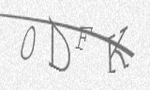

In [294]:
image = cv2.imread(captcha_images[9])
Image.fromarray(image)

In [295]:
image.shape

(90, 150, 3)

In [296]:
s = Image.open(captcha_images[1])

In [297]:
s.getpixel((2,5))

(248, 248, 248)

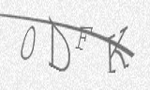

In [298]:
## Converting the image to Gray scale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
Image.fromarray(gray)

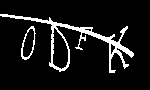

In [300]:
#Thresholding of the Image so that the noise at the backend is removed.
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
Image.fromarray(thresh)

# Exploring the Image 

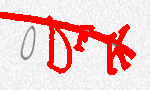

In [293]:
## Contours to identify if we can clearly identify each letter for splitting
## We can see clearly that having a line passing through creates an issue in separating each letter.
img = cv2.drawContours(image,contours,1,(255,0,0),3)
Image.fromarray(img)

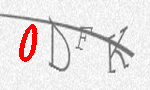

In [301]:
# Here 0 which is separate and doesnt merge with any letter or line so it is easily identified
img = cv2.drawContours(image,contours,0,(255,0,0),3)
Image.fromarray(img)

In [253]:
## The bounding rectangle points of those contours
for contour in contours:
    (x,y,w,h) = cv2.boundingRect(contour)
    print(x,y,w,h)

21 26 15 34
0 14 134 59


In [254]:
## If you see the different captchas and its history we can find that there is always a space separating the letters in a captcha 
#which makes these captchas vulnerable for machines to break them.
Image.fromarray(thresh[0:thresh.shape[0],10:40])

# Split letter for each of the image

In [255]:
# All the above mentioned sequences of  processing and splitting is executed on all the training images
#for every file in folder
for file in captcha_images:
    #Get the file name
    mystr = file.split('/')
    value = mystr[-1].split('\\')[1].split('.')[0]
    #Read image
    image = cv2.imread(file)
    #gray scaled image
    gray_scale = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    #Adding threshold to the image
    image = cv2.threshold(gray_scale,0,255,cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    #Slicing the image and saving the image file
    slicedImage = image[0:image.shape[0],10:40]
    letter = value[0]
    saveimage(letter,slicedImage) 
    slicedImage = image[0:image.shape[0],40:70]
    letter = value[1]
    saveimage(letter,slicedImage)
    slicedImage = image[0:image.shape[0],70:100]
    letter = value[2]
    saveimage(letter,slicedImage)
    slicedImage = image[0:image.shape[0],100:130]
    letter = value[3]
    saveimage(letter,slicedImage)

# Training the Classifier model

In [256]:
from keras.models import Sequential,load_model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator

In [257]:
train_datagen = ImageDataGenerator(rescale = 1./255)

In [258]:
## Training data generation - from directory Preprocessed
training_set = train_datagen.flow_from_directory('Preprocessed/',
target_size = (32, 32),
class_mode = 'categorical',color_mode='grayscale')

Found 3970 images belonging to 36 classes.


In [259]:
## Printing the different classes - 0 to 35 classes - refers to 0-9 and A-Z
training_set.classes

array([ 0,  0,  0, ..., 35, 35, 35])

# CNN Architecture

In [261]:
## Below architecture was chosen after iterations and based on https://elitedatascience.com/keras-tutorial-deep-learning-in-python
classifier = Sequential()
classifier.add(Conv2D(32, (5, 5), input_shape = (32, 32, 1), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2),strides=(2,2)))
classifier.add(Conv2D(32, (5, 5), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2),strides=(2,2)))
classifier.add(Flatten())
classifier.add(Dense(units = 500, activation = 'relu'))
classifier.add(Dense(units = 36, activation = 'softmax'))
# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [262]:
## Fitting the model
classifier.fit_generator(training_set,steps_per_epoch=2000,epochs=10)

Epoch 1/10
2000/2000 [==============================] - 133s - loss: 0.4045 - acc: 0.8867   
Epoch 2/10
2000/2000 [==============================] - 128s - loss: 0.0043 - acc: 0.9997   
Epoch 3/10
2000/2000 [==============================] - 129s - loss: 0.0041 - acc: 0.9997   
Epoch 4/10
2000/2000 [==============================] - 132s - loss: 0.0040 - acc: 0.9997   
Epoch 5/10
2000/2000 [==============================] - 130s - loss: 0.0040 - acc: 0.9997   
Epoch 6/10
2000/2000 [==============================] - 133s - loss: 0.0040 - acc: 0.9997   
Epoch 7/10
2000/2000 [==============================] - 133s - loss: 0.0040 - acc: 0.9997   
Epoch 8/10
2000/2000 [==============================] - 127s - loss: 0.0040 - acc: 0.9997   
Epoch 9/10
2000/2000 [==============================] - 183s - loss: 0.0040 - acc: 0.9997   
Epoch 10/10
2000/2000 [==============================] - 165s - loss: 0.0040 - acc: 0.9997   


In [265]:
## Dictionary which includes the mapping of the classes to the actual letters or numbers
d = training_set.class_indices

# Save the trained model

In [263]:
## Hierarchical Data format file to save the model. So that we dont have to run the entire sequence of program again.
classifier.save('captchaclassifier.hdf5')

# Check the trained model on Test data

In [278]:
# Load the saved model
captcha_model = load_model('captchaclassifier.hdf5')

In [279]:
#Get list of all Test files from the Test_data directory
captcha_image_files =  glob.glob(os.path.join('Test_data', "*"))

In [280]:
dict_class = {v:k for k,v in d.items()}

# Prediction logic for the test data

In [282]:
# Counter to count the number of correct predictions
count=0

## Predict function to test all the images from the Test_data directory
for file in captcha_image_files:
    combine = []
    #Get the file name
    mystr = file.split('\\')
    value1 = mystr[-1].split('.')[0]
    #Read image
    image = cv2.imread(file)
    gray_scale = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image = cv2.threshold(gray_scale,0,255,cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    #Slicing the image and saving the file
    slicedImage = image[0:90,10:40]
    resized = cv2.resize(slicedImage,(32,32))
    img= np.expand_dims(resized,axis=2)
    img = np.expand_dims(img,axis=0)
    pred = captcha_model.predict_classes(img)
    first = dict_class[pred[0]]
    combine.append(first)
    #Second Letter
    slicedImage = image[0:90,40:70]
    resized = cv2.resize(slicedImage,(32,32))
    img= np.expand_dims(resized,axis=2)
    img = np.expand_dims(img,axis=0)
    pred = captcha_model.predict_classes(img)
    second = dict_class[pred[0]]
    combine.append(second)
    #Third Letter
    slicedImage = image[0:90,70:100]
    resized = cv2.resize(slicedImage,(32,32))
    img= np.expand_dims(resized,axis=2)
    img = np.expand_dims(img,axis=0)
    pred = captcha_model.predict_classes(img)
    third = dict_class[pred[0]]
    combine.append(third)
    #Fourth letter
    slicedImage = image[0:90,100:130]
    resized = cv2.resize(slicedImage,(32,32))
    img= np.expand_dims(resized,axis=2)
    img= np.expand_dims(img,axis=0)
    pred = captcha_model.predict_classes(img)
    fourth = dict_class[pred[0]]
    combine.append(fourth)
    predict = ''.join(combine)
    print(predict)
    print(value1)
    print("------------")
    ## If the predicted and actual captcha letters match increment the counter
    if value1 == predict:
        count+=1

1/1 [==============================] - 0s
004E
004E
------------
1/1 [==============================] - 0s
005P
005P
------------
1/1 [==============================] - 0s
029K
025K
------------
1/1 [==============================] - 0s
03N0
03N0
------------
1/1 [==============================] - 0s
04L8
04L8
------------
1/1 [==============================] - 0s
04Z4
04ZZ
------------
1/1 [==============================] - 0s
05WQ
052Q
------------
1/1 [==============================] - 0s
063H
0630
------------
1/1 [==============================] - 0s
0BH1
0BS1
------------
1/1 [==============================] - 0s
0BN1
0BX1
------------
1/1 [==============================] - 0s
0CTE
0CTE
------------
1/1 [==============================] - 0s
0D1O
0D1O
------------
1/1 [==============================] - 0s
0D8M
0D8D
------------
1/1 [==============================] - 0s
0D9V
0D9V
------------
1/1 [==============================] - 0s
0E0S
0E0S
------------
1/1 [====================

1/1 [==============================] - 0s
1N29
1N29
------------
1/1 [==============================] - 0s
1NFI
1NFI
------------
1/1 [==============================] - 0s
1NMP
1NMP
------------
1/1 [==============================] - 0s
4P1J
1P1J
------------
1/1 [==============================] - 0s
1RPC
1RPC
------------
1/1 [==============================] - 0s
1SIU
1SIU
------------
1/1 [==============================] - 0s
1SXS
1SXS
------------
1/1 [==============================] - 0s
1M1W
1U1W
------------
1/1 [==============================] - 0s
1UQV
1UQV
------------
1/1 [==============================] - 0s
1V5Y
1V5Y
------------
1/1 [==============================] - 0s
1MP4
1VP4
------------
1/1 [==============================] - 0s
1XM8
1XU3
------------
1/1 [==============================] - 0s
1YG0
1YG0
------------
1/1 [==============================] - 0s
1Z0Y
1Z0Y
------------
1/1 [==============================] - 0s
2NKZ
21KZ
------------
1/1 [====================

1/1 [==============================] - 0s
2QSY
2QSY
------------
1/1 [==============================] - 0s
2V6R
2V6R
------------
1/1 [==============================] - 0s
2XCI
2XCI
------------
1/1 [==============================] - 0s
2NLA
2XLA
------------
1/1 [==============================] - 0s
2XTN
2XTN
------------
1/1 [==============================] - 0s
2XY6
2XY6
------------
1/1 [==============================] - 0s
2YK3
2YK3
------------
1/1 [==============================] - 0s
2YOD
2YOD
------------
1/1 [==============================] - 0s
2ZBX
2ZBX
------------
1/1 [==============================] - 0s
302C
302C
------------
1/1 [==============================] - 0s
33G2
33C2
------------
1/1 [==============================] - 0s
34BF
34BF
------------
1/1 [==============================] - 0s
A4M1
34M1
------------
1/1 [==============================] - 0s
38DA
35DA
------------
1/1 [==============================] - 0s
36PX
36PX
------------
1/1 [====================

1/1 [==============================] - 0s
3XW1
3XW1
------------
1/1 [==============================] - 0s
4107
4107
------------
1/1 [==============================] - 0s
45HH
45HH
------------
1/1 [==============================] - 0s
46PN
46PN
------------
1/1 [==============================] - 0s
48M5
48M5
------------
1/1 [==============================] - 0s
4921
4921
------------
1/1 [==============================] - 0s
49Q5
49Q5
------------
1/1 [==============================] - 0s
4FVU
4FVU
------------
1/1 [==============================] - 0s
4GKB
4GKB
------------
1/1 [==============================] - 0s
4GRM
4GRM
------------
1/1 [==============================] - 0s
4IAT
4IAT
------------
1/1 [==============================] - 0s
44G8
4IGS
------------
1/1 [==============================] - 0s
4LB3
4LB3
------------
1/1 [==============================] - 0s
4MZ9
4MZO
------------
1/1 [==============================] - 0s
4N0K
4N0K
------------
1/1 [====================

1/1 [==============================] - 0s
5J7T
5J7T
------------
1/1 [==============================] - 0s
5QL4
5QL4
------------
1/1 [==============================] - 0s
5SFF
5SFF
------------
1/1 [==============================] - 0s
4V8H
5V8H
------------
1/1 [==============================] - 0s
5ZAC
5ZAC
------------
1/1 [==============================] - 0s
606A
606A
------------
1/1 [==============================] - 0s
60OO
60OO
------------
1/1 [==============================] - 0s
61WY
617Y
------------
1/1 [==============================] - 0s
65XE
65XE
------------
1/1 [==============================] - 0s
678U
678U
------------
1/1 [==============================] - 0s
67H0
67H0
------------
1/1 [==============================] - 0s
67KF
67KF
------------
1/1 [==============================] - 0s
688N
685N
------------
1/1 [==============================] - 0s
690X
690X
------------
1/1 [==============================] - 0s
6AID
6AID
------------
1/1 [====================

1/1 [==============================] - 0s
7A0S
7A0S
------------
1/1 [==============================] - 0s
7AEU
7AEU
------------
1/1 [==============================] - 0s
7AZ7
7AZ7
------------
1/1 [==============================] - 0s
7B0C
7B0C
------------
1/1 [==============================] - 0s
7B69
7B69
------------
1/1 [==============================] - 0s
1P4Y
7C4Y
------------
1/1 [==============================] - 0s
7ENT
7ENT
------------
1/1 [==============================] - 0s
7F90
7F30
------------
1/1 [==============================] - 0s
7H00
7H00
------------
1/1 [==============================] - 0s
7JXB
7JXD
------------
1/1 [==============================] - 0s
7WA0
7KA0
------------
1/1 [==============================] - 0s
7NKY
7NKY
------------
1/1 [==============================] - 0s
7NXX
7NXX
------------
1/1 [==============================] - 0s
7PZI
7PZI
------------
1/1 [==============================] - 0s
7QPW
7QPW
------------
1/1 [====================

1/1 [==============================] - 0s
8LFC
8LFC
------------
1/1 [==============================] - 0s
805E
8O5E
------------
1/1 [==============================] - 0s
8QRT
8QRT
------------
1/1 [==============================] - 0s
8RWF
8R8F
------------
1/1 [==============================] - 0s
8STR
8STR
------------
1/1 [==============================] - 0s
8VCR
8VCR
------------
1/1 [==============================] - 0s
8VW4
8VWA
------------
1/1 [==============================] - 0s
8WB3
8WB3
------------
1/1 [==============================] - 0s
8XY4
8XY4
------------
1/1 [==============================] - 0s
8YNO
8YKO
------------
1/1 [==============================] - 0s
90N7
90N7
------------
1/1 [==============================] - 0s
91A0
91A0
------------
1/1 [==============================] - 0s
927U
927U
------------
1/1 [==============================] - 0s
93EL
93EL
------------
1/1 [==============================] - 0s
93OY
93OY
------------
1/1 [====================

1/1 [==============================] - 0s
A754
A754
------------
1/1 [==============================] - 0s
A91M
A91M
------------
1/1 [==============================] - 0s
A9NF
A9NF
------------
1/1 [==============================] - 0s
AA7V
AA7V
------------
1/1 [==============================] - 0s
AAGU
AAGG
------------
1/1 [==============================] - 0s
AAHZ
AAHZ
------------
1/1 [==============================] - 0s
ABR1
ABR1
------------
1/1 [==============================] - 0s
AD4W
AD48
------------
1/1 [==============================] - 0s
AE6A
AE6R
------------
1/1 [==============================] - 0s
AG7Q
AG7Q
------------
1/1 [==============================] - 0s
AG9L
AG9I
------------
1/1 [==============================] - 0s
AH9Y
AH9Y
------------
1/1 [==============================] - 0s
ALU3
ALU3
------------
1/1 [==============================] - 0s
AM0C
AM0C
------------
1/1 [==============================] - 0s
ANFT
ANFT
------------
1/1 [====================

1/1 [==============================] - 0s
BP1W
BP1W
------------
1/1 [==============================] - 0s
BQRW
BQRW
------------
1/1 [==============================] - 0s
BQWU
BQZJ
------------
1/1 [==============================] - 0s
BRZ1
BRZ1
------------
1/1 [==============================] - 0s
BSZK
BSZY
------------
1/1 [==============================] - 0s
BT7W
BT7W
------------
1/1 [==============================] - 0s
BUAN
BUAN
------------
1/1 [==============================] - 0s
BUQC
BUQC
------------
1/1 [==============================] - 0s
BWIA
BWIA
------------
1/1 [==============================] - 0s
BX03
BX03
------------
1/1 [==============================] - 0s
BXWB
BXSB
------------
1/1 [==============================] - 0s
BYAF
BYRF
------------
1/1 [==============================] - 0s
CHWB
C0WB
------------
1/1 [==============================] - 0s
C1W2
C1W2
------------
1/1 [==============================] - 0s
C35W
C358
------------
1/1 [====================

1/1 [==============================] - 0s
CVF7
CVF7
------------
1/1 [==============================] - 0s
CW0F
CW0F
------------
1/1 [==============================] - 0s
CW7C
CW7C
------------
1/1 [==============================] - 0s
CWTY
CWTY
------------
1/1 [==============================] - 0s
D0IZ
D0IZ
------------
1/1 [==============================] - 0s
D14Z
D14Z
------------
1/1 [==============================] - 0s
D1VQ
D1VQ
------------
1/1 [==============================] - 0s
D4AW
D4AZ
------------
1/1 [==============================] - 0s
D5OL
D5OL
------------
1/1 [==============================] - 0s
D5ZY
D5ZY
------------
1/1 [==============================] - 0s
D70G
D7DG
------------
1/1 [==============================] - 0s
D7XM
D7XM
------------
1/1 [==============================] - 0s
D95K
D95X
------------
1/1 [==============================] - 0s
D9OP
D9OP
------------
1/1 [==============================] - 0s
DA1L
DA1L
------------
1/1 [====================

1/1 [==============================] - 0s
E8Q6
E8Q6
------------
1/1 [==============================] - 0s
EBFX
EBFX
------------
1/1 [==============================] - 0s
EC05
EC05
------------
1/1 [==============================] - 0s
EC4Z
EC4Z
------------
1/1 [==============================] - 0s
EDY8
EDY5
------------
1/1 [==============================] - 0s
EGBH
EGBH
------------
1/1 [==============================] - 0s
EGGW
EGGR
------------
1/1 [==============================] - 0s
EH8A
EH8A
------------
1/1 [==============================] - 0s
EHII
EHII
------------
1/1 [==============================] - 0s
EHRW
EHRW
------------
1/1 [==============================] - 0s
EK1B
EK1B
------------
1/1 [==============================] - 0s
EKMP
EKMP
------------
1/1 [==============================] - 0s
EMGT
EMGT
------------
1/1 [==============================] - 0s
EO7J
EO7J
------------
1/1 [==============================] - 0s
EOBF
EOPF
------------
1/1 [====================

1/1 [==============================] - 0s
FPR4
FPR4
------------
1/1 [==============================] - 0s
FBY1
FPY1
------------
1/1 [==============================] - 0s
FS61
FS61
------------
1/1 [==============================] - 0s
FVQF
FVCF
------------
1/1 [==============================] - 0s
FVWG
FVWG
------------
1/1 [==============================] - 0s
FWTM
FWTH
------------
1/1 [==============================] - 0s
FYA2
FYA2
------------
1/1 [==============================] - 0s
FYJC
FYJC
------------
1/1 [==============================] - 0s
FYPW
FYPW
------------
1/1 [==============================] - 0s
40W6
G0W6
------------
1/1 [==============================] - 0s
G19O
G19O
------------
1/1 [==============================] - 0s
G4DT
G4DT
------------
1/1 [==============================] - 0s
G4MR
G4MR
------------
1/1 [==============================] - 0s
G6OQ
G6CQ
------------
1/1 [==============================] - 0s
G6BW
G6G5
------------
1/1 [====================

1/1 [==============================] - 0s
H87O
H87O
------------
1/1 [==============================] - 0s
H89J
H89J
------------
1/1 [==============================] - 0s
HBBL
HBOL
------------
1/1 [==============================] - 0s
HBVN
HBVN
------------
1/1 [==============================] - 0s
HCIT
HCIT
------------
1/1 [==============================] - 0s
HCUU
HCUU
------------
1/1 [==============================] - 0s
HD14
HD14
------------
1/1 [==============================] - 0s
HFIR
HFIR
------------
1/1 [==============================] - 0s
HJRQ
HJRQ
------------
1/1 [==============================] - 0s
HK00
HKQ0
------------
1/1 [==============================] - 0s
WM2L
HM2L
------------
1/1 [==============================] - 0s
HM4N
HM4N
------------
1/1 [==============================] - 0s
HM8A
HM8A
------------
1/1 [==============================] - 0s
H0H1
HOH1
------------
1/1 [==============================] - 0s
H0J2
HOJ2
------------
1/1 [====================

1/1 [==============================] - 0s
I818
IS18
------------
1/1 [==============================] - 0s
ISCL
ISCL
------------
1/1 [==============================] - 0s
IS0I
ISOI
------------
1/1 [==============================] - 0s
18XS
ISXS
------------
1/1 [==============================] - 0s
ITS8
ITS3
------------
1/1 [==============================] - 0s
IX5N
IX5R
------------
1/1 [==============================] - 0s
IYA0
IYA0
------------
1/1 [==============================] - 0s
IZ3N
IZ3N
------------
1/1 [==============================] - 0s
IZNN
IZNN
------------
1/1 [==============================] - 0s
J1C7
J1C7
------------
1/1 [==============================] - 0s
J23B
J23B
------------
1/1 [==============================] - 0s
J334
J334
------------
1/1 [==============================] - 0s
J372
J372
------------
1/1 [==============================] - 0s
J3PQ
J3PQ
------------
1/1 [==============================] - 0s
J4WK
J3WK
------------
1/1 [====================

1/1 [==============================] - 0s
K0BV
K0BV
------------
1/1 [==============================] - 0s
K405
K205
------------
1/1 [==============================] - 0s
W289
K289
------------
1/1 [==============================] - 0s
K2JB
K2JB
------------
1/1 [==============================] - 0s
K2L1
K2L1
------------
1/1 [==============================] - 0s
K52W
K52W
------------
1/1 [==============================] - 0s
W544
K544
------------
1/1 [==============================] - 0s
K6D7
K6D7
------------
1/1 [==============================] - 0s
K6NI
K6NI
------------
1/1 [==============================] - 0s
K6VQ
K6VQ
------------
1/1 [==============================] - 0s
K8JH
K8JH
------------
1/1 [==============================] - 0s
KBZI
KBZI
------------
1/1 [==============================] - 0s
KD69
KD69
------------
1/1 [==============================] - 0s
KEVG
KEVG
------------
1/1 [==============================] - 0s
KGDF
KGDF
------------
1/1 [====================

1/1 [==============================] - 0s
LFDL
LFDL
------------
1/1 [==============================] - 0s
LGLO
LGLO
------------
1/1 [==============================] - 0s
MH8T
LH8T
------------
1/1 [==============================] - 0s
LJYM
LJYM
------------
1/1 [==============================] - 0s
LK1F
LK1F
------------
1/1 [==============================] - 0s
LKRI
LKRI
------------
1/1 [==============================] - 0s
LMH9
LMH9
------------
1/1 [==============================] - 0s
LNW4
LNW4
------------
1/1 [==============================] - 0s
LO7D
LO7D
------------
1/1 [==============================] - 0s
LOA1
LOA1
------------
1/1 [==============================] - 0s
L0D9
LOD9
------------
1/1 [==============================] - 0s
MQUU
LQUU
------------
1/1 [==============================] - 0s
LR5A
LR5S
------------
1/1 [==============================] - 0s
LT2F
LT2F
------------
1/1 [==============================] - 0s
LU2V
LU2V
------------
1/1 [====================

1/1 [==============================] - 0s
MVP8
MVP5
------------
1/1 [==============================] - 0s
MXB0
MXB0
------------
1/1 [==============================] - 0s
MZ4K
MZ4T
------------
1/1 [==============================] - 0s
MZZW
MZZW
------------
1/1 [==============================] - 0s
N070
N070
------------
1/1 [==============================] - 0s
N0PV
N0PV
------------
1/1 [==============================] - 0s
N1R1
N1R1
------------
1/1 [==============================] - 0s
N1VN
N1VN
------------
1/1 [==============================] - 0s
N3B8
N3B8
------------
1/1 [==============================] - 0s
N3BB
N3BB
------------
1/1 [==============================] - 0s
N403
N403
------------
1/1 [==============================] - 0s
N43G
N43G
------------
1/1 [==============================] - 0s
N5NR
N5NR
------------
1/1 [==============================] - 0s
N6FI
N6FI
------------
1/1 [==============================] - 0s
NAOB
NAOB
------------
1/1 [====================

------------
1/1 [==============================] - 0s
O0KP
O0KP
------------
1/1 [==============================] - 0s
O0MN
O0MN
------------
1/1 [==============================] - 0s
O1EX
O1EX
------------
1/1 [==============================] - 0s
O1G3
O1G3
------------
1/1 [==============================] - 0s
B2OP
O2OP
------------
1/1 [==============================] - 0s
03M4
O3M4
------------
1/1 [==============================] - 0s
O41K
O41K
------------
1/1 [==============================] - 0s
O456
O456
------------
1/1 [==============================] - 0s
OWBA
O8BA
------------
1/1 [==============================] - 0s
O9FP
O9FP
------------
1/1 [==============================] - 0s
OAFA
OAFA
------------
1/1 [==============================] - 0s
0CM0
OCM0
------------
1/1 [==============================] - 0s
ODW9
ODW9
------------
1/1 [==============================] - 0s
OEPW
OEPE
------------
1/1 [==============================] - 0s
OFD2
OFD2
------------
1/1 [=======

1/1 [==============================] - 0s
QN5H
QN5H
------------
1/1 [==============================] - 0s
QNQU
QNQU
------------
1/1 [==============================] - 0s
QO3F
QO3F
------------
1/1 [==============================] - 0s
QOMD
QOMD
------------
1/1 [==============================] - 0s
QQ4U
QQ3U
------------
1/1 [==============================] - 0s
QTD1
QTD1
------------
1/1 [==============================] - 0s
QWWM
QWWM
------------
1/1 [==============================] - 0s
R0HF
R0HF
------------
1/1 [==============================] - 0s
R0LG
R0LG
------------
1/1 [==============================] - 0s
RA2E
R32E
------------
1/1 [==============================] - 0s
R3QS
R3QS
------------
1/1 [==============================] - 0s
R4QI
R4CI
------------
1/1 [==============================] - 0s
R6HY
R6HY
------------
1/1 [==============================] - 0s
R6Z0
R6Z0
------------
1/1 [==============================] - 0s
R720
R720
------------
1/1 [====================

1/1 [==============================] - 0s
TJX9
TJX9
------------
1/1 [==============================] - 0s
TKC9
TKC9
------------
1/1 [==============================] - 0s
TMNW
TMN6
------------
1/1 [==============================] - 0s
TN3Q
TN3Q
------------
1/1 [==============================] - 0s
TOWO
TOWO
------------
1/1 [==============================] - 0s
TPB1
TPB1
------------
1/1 [==============================] - 0s
TPMS
TPMS
------------
1/1 [==============================] - 0s
TRBW
TRBW
------------
1/1 [==============================] - 0s
TRII
TRII
------------
1/1 [==============================] - 0s
TSV5
TSV5
------------
1/1 [==============================] - 0s
TTO0
TTOO
------------
1/1 [==============================] - 0s
TTVX
TTVX
------------
1/1 [==============================] - 0s
TUXW
TUXS
------------
1/1 [==============================] - 0s
TVFX
TVFX
------------
1/1 [==============================] - 0s
TWT4
TWI4
------------
1/1 [====================

1/1 [==============================] - 0s
UQ8B
UQ86
------------
1/1 [==============================] - 0s
US6J
US6J
------------
1/1 [==============================] - 0s
USI1
USI1
------------
1/1 [==============================] - 0s
UT3S
UT3S
------------
1/1 [==============================] - 0s
UU8O
UU8O
------------
1/1 [==============================] - 0s
UUXF
UUXC
------------
1/1 [==============================] - 0s
UWUE
UWUE
------------
1/1 [==============================] - 0s
UYDQ
UYDQ
------------
1/1 [==============================] - 0s
UYHY
UYHY
------------
1/1 [==============================] - 0s
UYNG
UYNG
------------
1/1 [==============================] - 0s
V1SH
V1SH
------------
1/1 [==============================] - 0s
V83Q
V23Q
------------
1/1 [==============================] - 0s
V2D0
V2D7
------------
1/1 [==============================] - 0s
V3A8
V328
------------
1/1 [==============================] - 0s
V3NQ
V3NQ
------------
1/1 [====================

1/1 [==============================] - 0s
XGAR
XGAR
------------
1/1 [==============================] - 0s
XIOD
XIOD
------------
1/1 [==============================] - 0s
XITA
XITA
------------
1/1 [==============================] - 0s
XJIF
XJIF
------------
1/1 [==============================] - 0s
XJYU
XJYU
------------
1/1 [==============================] - 0s
XKVJ
XKVJ
------------
1/1 [==============================] - 0s
XLKN
XLKN
------------
1/1 [==============================] - 0s
XNML
XNML
------------
1/1 [==============================] - 0s
XOI4
XOI4
------------
1/1 [==============================] - 0s
XPA0
XPA0
------------
1/1 [==============================] - 0s
XTU9
XTU7
------------
1/1 [==============================] - 0s
XUGT
XUCT
------------
1/1 [==============================] - 0s
XUHX
XUHX
------------
1/1 [==============================] - 0s
XUTZ
XUTZ
------------
1/1 [==============================] - 0s
Y0KQ
Y0KQ
------------
1/1 [====================

# Metrics - Accuracy of prediction

In [283]:
## Number of correct predictions is stored in count variable
Accuracy = count/len(captcha_image_files)
print(Accuracy)

0.7012750455373407


# Insights

-- The applications containing Captchas with no ‘noise’ included are at the highest risk of being automated.

-- The Captchas with noise such as lines across the text are at a medium risk of a breach.

-- Observing the different captchas and its history we can find that there is always a space separating the letters in a captcha which makes these captchas vulnerable for machines to break them.

-- If the intensity of the noise is less than the actual text and if not converging on the text, the noise can be removed by thresholding or binarizing.


# Recommendations and Future Scope

-- Captchas with Images or a combination of Images and text with varying intensity of noises is an efficient way to be used in applications and would be difficult for machines to learn the pattern.

-- As per Prof. Balaji’s recommendation, this project can be extended to classify the strength of any Captcha as Low, Medium or High.
